In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns
import os
import time
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
from sklearn.neighbors import KNeighborsClassifier
#Setting options
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
#Set Default option
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_rows = 3000
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier  
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector
from scipy import stats

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [7]:
sgemm_product = pd.read_csv("sgemm_product.csv")
sgemm_product.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


In [8]:
sgemm_product.columns

Index(['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'STRM', 'STRN', 'SA', 'SB', 'Run1 (ms)', 'Run2 (ms)',
       'Run3 (ms)', 'Run4 (ms)'],
      dtype='object')

In [14]:
runs_cols = ['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)','Run4 (ms)']
sgemm_product['y']=sgemm_product[runs_cols].mean(axis=1)
sgemm_product

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms),y
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81,118.6625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1,17.96,17.77,17.77,17.77,17.8175
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0,36.04,36.03,36.04,36.03,36.0350
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1,35.28,34.82,35.27,35.27,35.1600
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0,28.43,28.49,28.44,28.45,28.4525


# Plotting the correlation

<AxesSubplot:>

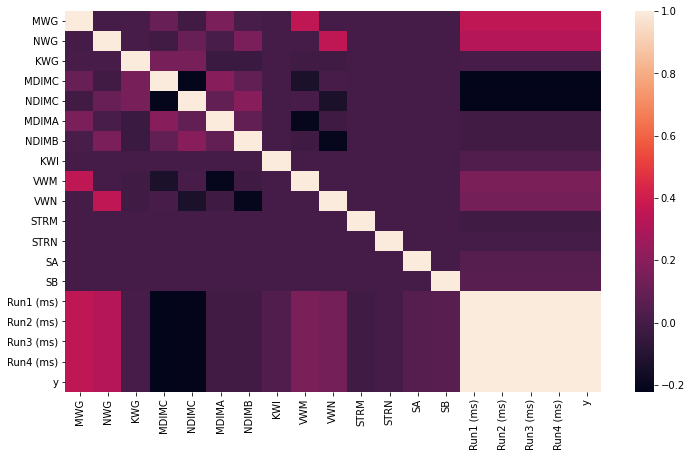

In [10]:
plt.figure(figsize=(12,7))
sns.heatmap(sgemm_product.corr())

## Checking for nans

In [11]:
sgemm_product.isnull().sum()

MWG          0
NWG          0
KWG          0
MDIMC        0
NDIMC        0
MDIMA        0
NDIMB        0
KWI          0
VWM          0
VWN          0
STRM         0
STRN         0
SA           0
SB           0
Run1 (ms)    0
Run2 (ms)    0
Run3 (ms)    0
Run4 (ms)    0
y            0
dtype: int64

## Removing outliers from data

In [12]:
def remove_outliers(df, cols):
    return df[(np.abs(stats.zscore(df[cols])) < 3).all(axis=1)]

In [17]:
sgemm_product = remove_outliers(sgemm_product, runs_cols)

In [21]:
y_hat = np.log(sgemm_product['y'])
y_mean = np.log(sgemm_product['y']).mean()
print("mean of y after taking log is coming to be",y_mean)
    
sgemm_product["y_sigmoid"]=np.log(sgemm_product['y']).apply(lambda y_hat : 1 if y_hat> y_mean else 0)

mean of y after taking log is coming to be 4.556193565790992


In [22]:
sgemm_product_log=sgemm_product[sgemm_product['y']<=1000]
sgemm_product_log

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms),y,y_sigmoid
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80,116.3700,1
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19,78.7050,0
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97,80.5650,0
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58,86.6375,0
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81,118.6625,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1,17.96,17.77,17.77,17.77,17.8175,0
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0,36.04,36.03,36.04,36.03,36.0350,0
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1,35.28,34.82,35.27,35.27,35.1600,0
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0,28.43,28.49,28.44,28.45,28.4525,0


In [23]:
sgemm_product_log['y_sigmoid'].value_counts()

0    139711
1     93331
Name: y_sigmoid, dtype: int64

## Making the continuous data for binary classification

<AxesSubplot:>

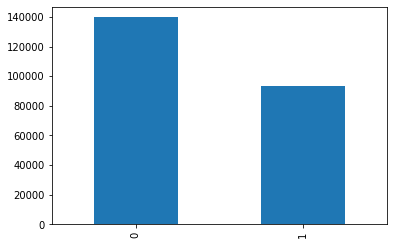

In [24]:
sgemm_product_log['y_sigmoid'].value_counts().plot(kind='bar')

In [25]:
sgemm_product_log=sgemm_product_log.drop([*runs_cols,'y'], axis=1)
sgemm_product_log

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,y_sigmoid
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,1
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,0
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,0
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,0
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1,0
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0,0
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1,0
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0,0


In [26]:
data=sgemm_product_log.copy()

## EDA

In [52]:
data = data.sample(4_000, replace=True)

In [58]:
def univariate_histograms(data, data2):
    nrows = 5
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * ncols, fig_size[1] * nrows))
    ax.flatten()

    for i, col in enumerate(data.columns):
        _ = sns.kdeplot(data=data[col].values.tolist(), ax=ax.flatten()[i], label='Sample')
        _ = sns.kdeplot(data=data2[col].values.tolist(), ax=ax.flatten()[i], label='Population')
        
        _ = ax.flatten()[i].set(title=col)
        _ = ax.flatten()[i].legend()
    
    _ = plt.suptitle('Univariate Distribution of Sample VS total population', fontsize=20)
    _ = plt.tight_layout(5.0)


def univariate_qq(data, data2):
    nrows = 5
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * ncols, fig_size[1] * nrows))
    ax.flatten()
    
    for i, col in enumerate(data.columns):
        ref_normal = np.random.normal(loc=np.mean(data[col].values), scale=np.std(data[col].values), size=int(1e4))
        ref_normal_quantiles = get_quantiles(ref_normal, 10)
        _ = sns.regplot(ref_normal_quantiles, get_quantiles(data[col].values, 10), ax=ax.flatten()[i])
        _ = sns.regplot(ref_normal_quantiles, get_quantiles(data2[col].values, 10), ax=ax.flatten()[i])
        _ = ax.flatten()[i].set(title=col)
    
    _ = plt.suptitle('QQ plot - ', fontsize=20)
    _ = plt.tight_layout(5.0)

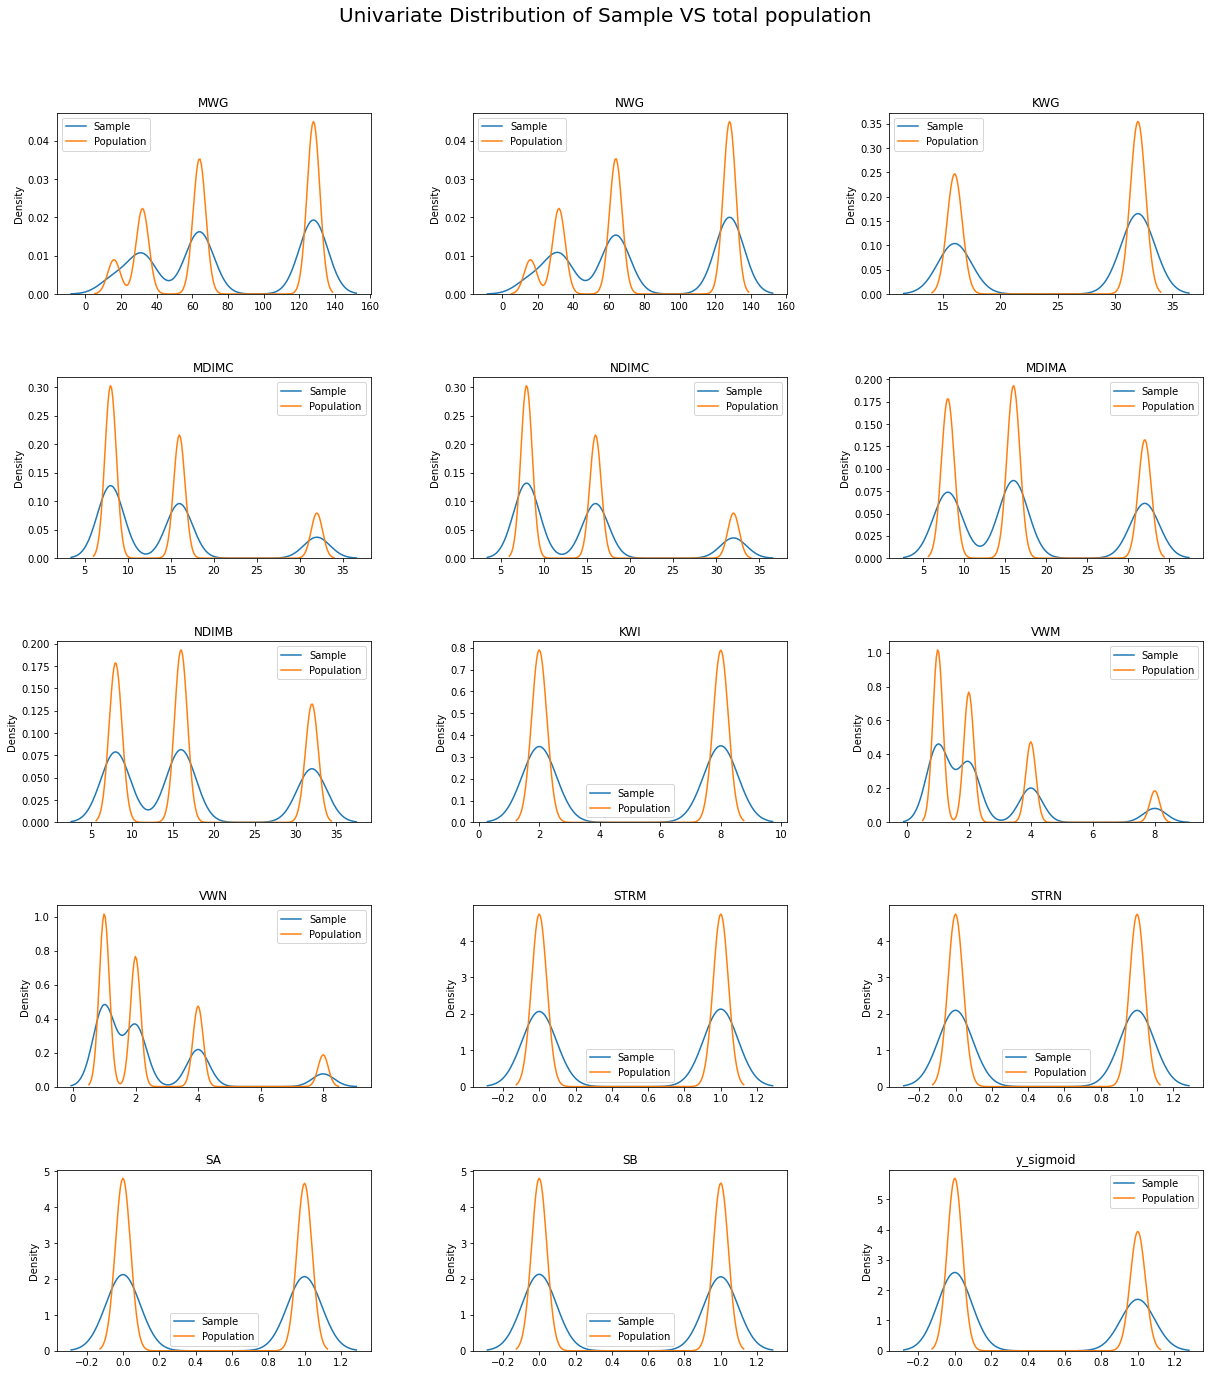

In [59]:
fig_size = plt.rcParams['figure.figsize']
univariate_histograms(data, sgemm_product)

## Plotting the univariate frequency using histograms of a randomly sampled set from the total population of sizes 4000. 

## The sampled set is a good candidate for modelling as we can see the overall distribution followed by samples is a good approximation of the population. If we want to better approximate, then the sample size has to be increased.


0    2414
1    1586
Name: y_sigmoid, dtype: int64


<AxesSubplot:>

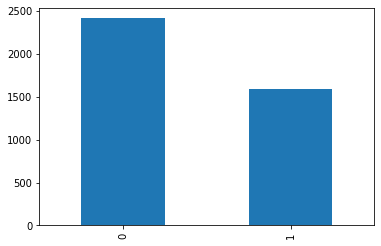

In [60]:
print(data['y_sigmoid'].value_counts())
data['y_sigmoid'].value_counts().plot(kind='bar')

## Conclusion - Not much correlation observered between the variables in sampled set

<AxesSubplot:>

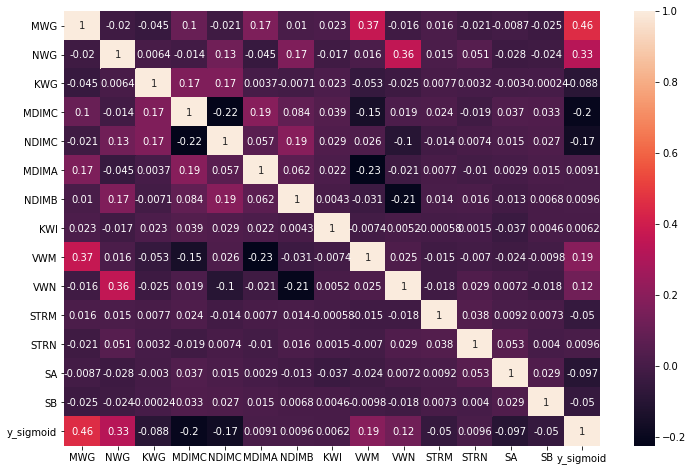

In [61]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=True)

In [65]:
#Independent Variables
X = data.drop('y_sigmoid', axis=1)
y = data['y_sigmoid']
y_pca = y.copy()
X1 = X.copy()

In [66]:
cols = X.columns

## Scaling the dataset to bring the data in same order of magnitudes for better analysis.

In [69]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Modelling

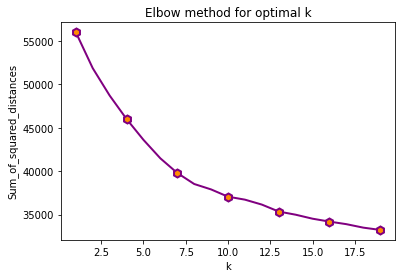

In [71]:
## Determining number of clusters
from sklearn.cluster import KMeans 
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km=km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    
## Checking out which SSE is low for different types of k means value
plt.plot(K, Sum_of_squared_distances, linewidth=2,color='purple',
         marker='h', markerfacecolor='darkorange', markeredgewidth=2,
         markersize=8, markevery=3)
# plt.plot(K,Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow method for optimal k')
plt.show()

## From the graph we can see that the ELBOW comes around as 6. Now, we will use 6 as number of clusters for futher clustering

Accuracy: 0.1825


Text(0.5, 1.0, 'KMeans on Train Data')

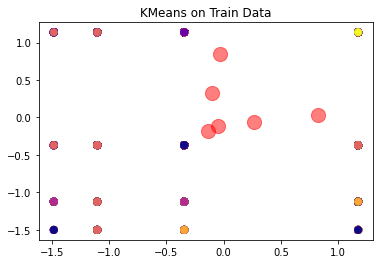

In [72]:
## K-Means Clustering Algorithm 
## Train Accuracy and Train Plot 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6) 
kmeans.fit(X_train)
y=np.array(y_train)
y=y.astype(float)
correct = 0
prediction=[]
for i in range(len(X_train)):
    predict_me = np.array(X_train[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction.append(kmeans.predict(predict_me))
    if prediction[i] == y[i]:
        correct += 1
print('Accuracy:',correct/len(X_train))
yp=kmeans.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=yp, s=50, cmap='plasma')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.title('KMeans on Train Data')

# PCA

In [73]:
# X.shape
y.shape
# y = np.array(data['y_sigmoid'])

(2800,)

In [75]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y_pca, test_size=0.3, random_state=1)

In [76]:
from sklearn.decomposition import PCA
pca = PCA()
pca_X_train=pca.fit_transform(X_train_pca)
pca_X_test=pca.fit_transform(X_test_pca)

In [77]:
pca.get_covariance()

array([[ 1.00518587e+00,  1.07867447e-02, -4.94968544e-02,
         1.02088144e-01, -5.95846800e-03,  1.54302064e-01,
        -9.65348444e-04,  2.22002481e-02,  3.76090267e-01,
         3.16619876e-03,  1.76273153e-02, -1.65708226e-02,
        -9.03954907e-03, -3.66997511e-02],
       [ 1.07867447e-02,  9.70456307e-01,  7.44716179e-04,
         1.39373512e-02,  9.41459575e-02, -1.64742225e-02,
         1.81885480e-01,  2.98879315e-02,  4.83506988e-02,
         3.15698753e-01,  8.48887235e-03,  4.93780137e-02,
        -2.17681278e-03, -2.04557257e-02],
       [-4.94968544e-02,  7.44716179e-04,  9.99295277e-01,
         1.82465276e-01,  2.12674707e-01, -2.88180901e-02,
         3.58748239e-02,  1.70084264e-02, -3.53200265e-02,
        -3.20733818e-02,  1.59449742e-02, -4.23120777e-02,
         2.52004963e-02, -1.56938985e-02],
       [ 1.02088144e-01,  1.39373512e-02,  1.82465276e-01,
         1.00231094e+00, -2.15022122e-01,  1.90646429e-01,
         1.43042242e-01,  3.09977079e-02, -1.

In [78]:
explained_variance=pca.explained_variance_ratio_
explained_variance

array([0.1133166 , 0.09855481, 0.09616418, 0.08944124, 0.08019445,
       0.07876958, 0.0754184 , 0.07235566, 0.06963546, 0.06405673,
       0.06005325, 0.03530846, 0.03442575, 0.03230543])

In [79]:
explained_variance=pd.DataFrame(explained_variance, index=cols)

In [80]:
explained_variance=explained_variance.rename(index={0: 'Variance'})

<AxesSubplot:>

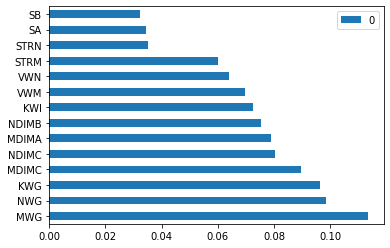

In [81]:
explained_variance.plot(kind='barh')

In [82]:
pca.get_covariance()

array([[ 1.00518587e+00,  1.07867447e-02, -4.94968544e-02,
         1.02088144e-01, -5.95846800e-03,  1.54302064e-01,
        -9.65348444e-04,  2.22002481e-02,  3.76090267e-01,
         3.16619876e-03,  1.76273153e-02, -1.65708226e-02,
        -9.03954907e-03, -3.66997511e-02],
       [ 1.07867447e-02,  9.70456307e-01,  7.44716179e-04,
         1.39373512e-02,  9.41459575e-02, -1.64742225e-02,
         1.81885480e-01,  2.98879315e-02,  4.83506988e-02,
         3.15698753e-01,  8.48887235e-03,  4.93780137e-02,
        -2.17681278e-03, -2.04557257e-02],
       [-4.94968544e-02,  7.44716179e-04,  9.99295277e-01,
         1.82465276e-01,  2.12674707e-01, -2.88180901e-02,
         3.58748239e-02,  1.70084264e-02, -3.53200265e-02,
        -3.20733818e-02,  1.59449742e-02, -4.23120777e-02,
         2.52004963e-02, -1.56938985e-02],
       [ 1.02088144e-01,  1.39373512e-02,  1.82465276e-01,
         1.00231094e+00, -2.15022122e-01,  1.90646429e-01,
         1.43042242e-01,  3.09977079e-02, -1.

In [83]:
explained_variance=pca.explained_variance_ratio_
explained_variance

array([0.1133166 , 0.09855481, 0.09616418, 0.08944124, 0.08019445,
       0.07876958, 0.0754184 , 0.07235566, 0.06963546, 0.06405673,
       0.06005325, 0.03530846, 0.03442575, 0.03230543])

In [84]:
import plotly.graph_objects as go

explained_variance=explained_variance.astype(list)

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar( y=explained_variance)])
# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1, opacity=0.6)
fig.update_layout(title_text='Variance of individual features')
fig.show()

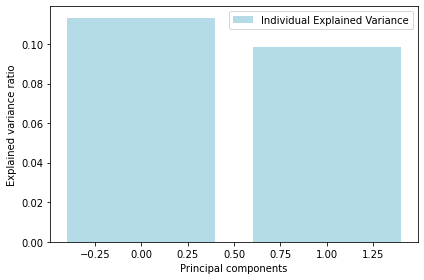

In [85]:
pca = PCA(n_components=2)
pca_X_train=pca.fit_transform(X_train_pca)
pca_X_test=pca.fit_transform(X_test_pca)

pca.get_covariance()

explained_variance=pca.explained_variance_ratio_
explained_variance

with plt.style.context('seaborn-bright'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(2), explained_variance, alpha=0.9, align='center', color='lightblue',
            label='Individual Explained Variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

# K-Means with PCA

0.16428571428571428


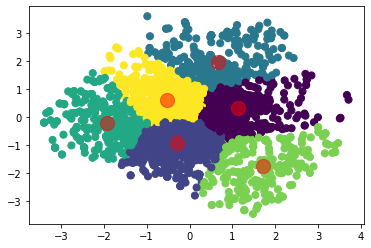

In [86]:
## K-Means Clustering Algorithm 
## Train Accuracy and Train Plot 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6) 
kmeans.fit(pca_X_train)
y=np.array(y_train_pca)
y=y.astype(float)
correct = 0
prediction=[]
for i in range(len(pca_X_train)):
    predict_me = np.array(pca_X_train[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction.append(kmeans.predict(predict_me))
    if prediction[i] == y[i]:
        correct += 1
print(correct/len(pca_X_train))
yp=kmeans.predict(pca_X_train)
plt.scatter(pca_X_train[:, 0], pca_X_train[:, 1], c=yp, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)

0.12583333333333332


Text(0.5, 1.0, 'KMeans with PCA')

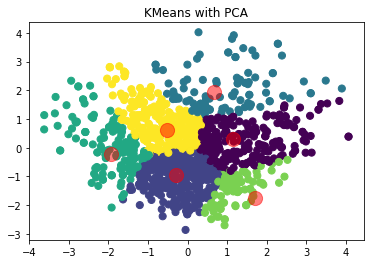

In [87]:
## Test Accuracy and Test Plot 
y=np.array(y_test_pca)
y=y.astype(float)
correct = 0
prediction=[]
for i in range(len(pca_X_test)):
    predict_me = np.array(pca_X_test[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction.append(kmeans.predict(predict_me))
    if prediction[i] == y[i]:
        correct += 1
print(correct/len(pca_X_test))
yp=kmeans.predict(pca_X_test)
plt.scatter(pca_X_test[:, 0], pca_X_test[:, 1], c=yp, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.title('KMeans with PCA')

In [104]:
from scipy.stats import chi2_contingency

stat, p, dof, expected = chi2_contingency(data)

alpha = 0.05

print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Variables are associated (reject H0)')
else:
    print('Variables are not associated(fail to reject H0)')

significance=0.050, p=0.000
Variables are associated (reject H0)


## By chi2 square test, we can there is no correlation in ordinal variables. Hence, we went for PCA.

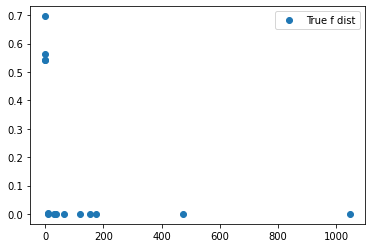

In [107]:
plt.plot(*f_classif(data.iloc[:, :-1], data.iloc[:, -1]), 'o', lw=2, label="True f dist")
plt.legend();

## Thus, we see in actual data, with f tests, that there was a correlation in data.

In [111]:
X_train, y_train.values

(array([[ 1.17517292, -0.3700618 , -1.26188453, ...,  1.00050013,
          1.01359237, -0.98363391],
        [ 1.17517292, -0.3700618 ,  0.79246554, ..., -0.99950012,
          1.01359237, -0.98363391],
        [-1.10266185, -0.3700618 ,  0.79246554, ...,  1.00050013,
         -0.98658991, -0.98363391],
        ...,
        [-1.10266185,  1.13847038,  0.79246554, ...,  1.00050013,
         -0.98658991,  1.0166384 ],
        [-0.34338359, -1.12432789,  0.79246554, ..., -0.99950012,
          1.01359237, -0.98363391],
        [-0.34338359,  1.13847038,  0.79246554, ...,  1.00050013,
         -0.98658991, -0.98363391]]),
 array([0, 1, 0, ..., 0, 0, 0]))

In [112]:
from sklearn.linear_model import LogisticRegression

In [122]:
fit = LogisticRegression().fit(X_train, y_train.values)
print(f"Accuracy of Logistic regression on train set {fit.score(X_train, y_train.values)}")

Accuracy of Logistic regression on train set 0.89


In [123]:
print(f"Accuracy of Logistic regression on train set {fit.score(X_test, y_test.values)}")

Accuracy of Logistic regression on train set 0.9183333333333333
